### Setup & Data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 3e-4 # 0.0003
BATCH_SIZE = 64
Z_DIM = 64 # Size of the "noise" vector we feed the generator
EPOCHS = 20 # Keep it short for demo

# 1. Prepare Data (Fashion MNIST)
# Transforms: Convert to Tensor and Normalize to range [-1, 1]
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.FashionMNIST(root="dataset/", transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Dataset loaded. Total images: {len(dataset)}")

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 205kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.80MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.5MB/s]

Dataset loaded. Total images: 60000


### The Two Brains (Generator & Discriminator)

In [2]:
# The Discriminator (The Detective)
# Input: 784 pixels (28x28 image flattened) -> Output: 1 number (Probability of being Real)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.LeakyReLU(0.2), # LeakyReLU is better for GANs than standard ReLU
            nn.Linear(256, 1),
            nn.Sigmoid() # Squashes output between 0 (Fake) and 1 (Real)
        )

    def forward(self, x):
        return self.disc(x)

# The Generator (The Forger)
# Input: Random Noise (Z_DIM) -> Output: 784 pixels (Fake Image)
class Generator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 28 * 28), # Output size same as real image
            nn.Tanh() # Normalizes output to [-1, 1] to match our data
        )

    def forward(self, noise):
        return self.gen(noise)

# Initialize
disc = Discriminator().to(device)
gen = Generator(Z_DIM).to(device)

# Optimizers (Two separate ones!)
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE)
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE)

# Loss function (Binary Cross Entropy - standard for Real vs Fake)
criterion = nn.BCELoss()

### The Training Loop (The War)

In [3]:
import numpy as np

print("Starting the training loop...")

for epoch in range(EPOCHS):
    for batch_idx, (real, _) in enumerate(loader):

        # Flatten images: [Batch, 1, 28, 28] -> [Batch, 784]
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        ### TRAIN DISCRIMINATOR: max log(D(real)) + log(1 - D(G(noise)))
        noise = torch.randn(batch_size, Z_DIM).to(device)
        fake = gen(noise) # The forger makes a batch of fakes

        # 1. Detective checks real images
        disc_real = disc(real).view(-1) # What does it think of the real ones?
        lossD_real = criterion(disc_real, torch.ones_like(disc_real)) # Should be 1 (Real)

        # 2. Detective checks fake images
        disc_fake = disc(fake.detach()).view(-1) # .detach() prevents training the generator here
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake)) # Should be 0 (Fake)

        lossD = (lossD_real + lossD_fake) / 2

        disc.zero_grad()
        lossD.backward()
        opt_disc.step()

        ### TRAIN GENERATOR: min log(1 - D(G(noise))) <-> max log(D(G(noise)))
        # The generator wants the discriminator to believe the fakes are REAL (1)
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output)) # We WANT the detective to say 1

        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

    print(f"Epoch [{epoch}/{EPOCHS}] Loss D: {lossD:.4f}, loss G: {lossG:.4f}")

Starting the training loop...
Epoch [0/20] Loss D: 0.1324, loss G: 2.0253
Epoch [1/20] Loss D: 0.2379, loss G: 2.2690
Epoch [2/20] Loss D: 0.3054, loss G: 2.2265
Epoch [3/20] Loss D: 0.2868, loss G: 2.0271
Epoch [4/20] Loss D: 0.3075, loss G: 2.3066
Epoch [5/20] Loss D: 0.2527, loss G: 2.7219
Epoch [6/20] Loss D: 0.6266, loss G: 1.1279
Epoch [7/20] Loss D: 0.2759, loss G: 2.4387
Epoch [8/20] Loss D: 0.4925, loss G: 2.0423
Epoch [9/20] Loss D: 0.3233, loss G: 2.1818
Epoch [10/20] Loss D: 0.3893, loss G: 2.0331
Epoch [11/20] Loss D: 0.3353, loss G: 2.1571
Epoch [12/20] Loss D: 0.3670, loss G: 1.9642
Epoch [13/20] Loss D: 0.4871, loss G: 2.0284
Epoch [14/20] Loss D: 0.5465, loss G: 1.8007
Epoch [15/20] Loss D: 0.3571, loss G: 2.0682
Epoch [16/20] Loss D: 0.4824, loss G: 1.3948
Epoch [17/20] Loss D: 0.4473, loss G: 2.2118
Epoch [18/20] Loss D: 0.5318, loss G: 1.4585
Epoch [19/20] Loss D: 0.2580, loss G: 2.6204


### Visualization

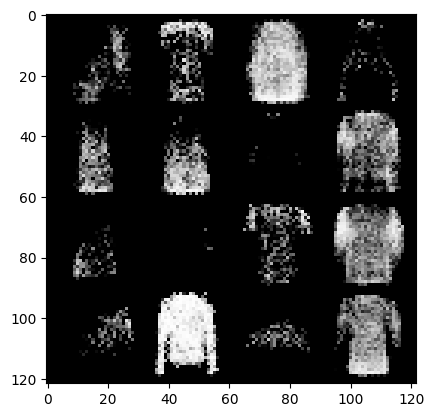

In [4]:
# Generate new fashion items from random noise
noise = torch.randn(32, Z_DIM).to(device)
fake_images = gen(noise).reshape(-1, 1, 28, 28)

# Plot them
def show_tensor_images(image_tensor, num_images=16, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu()
    image_grid = torchvision.utils.make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

show_tensor_images(fake_images)